In [1]:
import numpy as np

In [2]:
import cv2

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

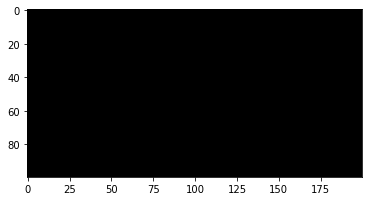

In [5]:
a = np.zeros((100, 200, 3))
plt.imshow(a)

In [6]:
#!/usr/bin/env python3
#
#   detector.py
#
#   Detect the tennis balls with OpenCV.
#
#   Subscribers:    /usb_cam/image_raw     Source image
#
#   Publishers:     /detector/image_raw    Debug image
#

# ROS Imports
# import rospy
import cv2
# import cv_bridge
import numpy as np
import random

import os
from itertools import combinations

# from std_msgs.msg      import Bool
# from sensor_msgs.msg   import Image, CameraInfo
# from nav_msgs.msg      import OccupancyGrid, MapMetaData
# from geometry_msgs.msg import Pose, Point, Quaternion

# Set the approximate piece side length (in pixels).  This is used to
# sub-divide the long side of connected pieces.
SIDELEN = 125

# Set the number of points per side to match against another side.
SIDEPOINTS = 20

class PuzzlePiece:
    # def __init__(self, bbox, centroid):
    #     self.x_center, self.y_center = centroid
    #     self.xmin, self.ymin, self.width, self.height, self.area = bbox

    def __init__(self, mask):
        self.update_mask(mask)
        
        self.color = tuple(map(int, np.random.random(size=3) * 255))

        self.matched = True
        self.removed = False

        self.img = None
        self.natural_img = None
        self.thomas_mask = None
    
    def update_mask(self, mask):
        ys, xs = np.where(mask)
        self.xmin, self.xmax = np.min(xs), np.max(xs)
        self.ymin, self.ymax = np.min(ys), np.max(ys)
        self.area   = np.sum(mask)
        self.width  = self.xmax - self.xmin
        self.height = self.ymax - self.ymin
        self.x_center = np.mean(xs).astype(int)
        self.y_center = np.mean(ys).astype(int)

        self.mask = mask.astype(np.float32)

    def copy(self):
        copy = PuzzlePiece(self.mask.copy())
        copy.img = self.img
        return copy

    def move_to(self, new_x_center, new_y_center):
        dx = new_x_center - self.x_center
        dy = new_y_center - self.y_center

        M = np.float32([
            [1, 0, dx],
            [0, 1, dy]
        ])
        new_mask = cv2.warpAffine(self.mask, M, self.mask.shape[::-1])
        self.update_mask(new_mask)

    def move_to_no_mask(self, new_x_center, new_y_center):
        dx = new_x_center - self.x_center
        dy = new_y_center - self.y_center
        self.xmin += dx
        self.xmax += dx
        self.ymin += dy
        self.ymax += dy
        self.x_center += dx
        self.y_center += dy
        self.mask = None # invalidates mask

    def rotate(self, theta):
        # theta in radians
        center = np.float32((self.x_center, self.y_center))
        rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=theta*180/np.pi, scale=1)
        new_mask = cv2.warpAffine(self.mask, rotate_matrix, self.mask.shape[::-1])
        self.update_mask(new_mask)

    def bounds_slice(self, padding=0):
        return (slice(max(0, self.ymin - padding), self.ymin+self.height+padding, 1), 
                slice(max(0, self.xmin - padding), self.xmin+self.width+padding, 1))

    def get_center(self):
        return (self.x_center, self.y_center)

    def set_img(self, img):
        self.img = img
    def set_natural_img(self, natural_img):
        self.natural_img = natural_img
    def get_color(self):
        return self.color
    def get_location(self):
        return (self.x_center, self.y_center)

    def __repr__(self):
        return f"<Puzzle Piece at (x={self.x_center}, y={self.y_center}), width={self.width}, height={self.height} with color={self.color}>"

    def matches(self, other):
        return (self.x_center - other.x_center) ** 2 + (self.y_center - other.y_center) ** 2 < 10**2

    def is_valid(self):
        if not (8000 < self.area or 25000 > self.area):
            return False
        if not (70 < self.width or 200 > self.width):
            return False
        if not (70 < self.height or 200 > self.height):
            return False
        return True

    def is_multiple(self):
        # Assume valid
        if self.area > 5000:
            return True
        if self.width > 120 or self.height > 120:
            return True
        return False

    def on_border_of_region(self, region):
        xmin, ymin, xmax, ymax = region
        return (self.xmin-1 <= xmin <= self.xmax+1) or \
               (self.xmin-1 <= xmax <= self.xmax+1) or \
               (self.ymin-1 <= ymin <= self.ymax+1) or \
               (self.ymin-1 <= ymax <= self.ymax+1)

    def fully_contained_in_region(self, region, buffer=0):
        xmin, ymin, xmax, ymax = region
        return (xmin + buffer < self.xmin < xmax - buffer) and \
               (xmin + buffer < self.xmax < xmax - buffer) and \
               (ymin + buffer < self.ymin < ymax - buffer) and \
               (ymin + buffer < self.ymax < ymax - buffer)

    def overlaps_with_region(self, region, buffer=0):
        xmin, ymin, xmax, ymax = region
        for (x, y) in [(xmin, ymin), (xmin, ymax), (xmax, ymin), (xmax, ymax)]:
            if (self.xmin - buffer < x < self.xmin + self.width + buffer) and \
               (self.ymin - buffer < y < self.ymin + self.height + buffer):
                return True
        for (x, y) in [(self.xmin, self.ymin),
                       (self.xmin, self.ymin+self.height),
                       (self.xmin+self.width, self.ymin),
                       (self.xmin+self.width, self.ymin+self.height)]:
            if (xmin - buffer < x < xmax + buffer) and (ymin - buffer < y < ymax + buffer):
                return True
        return False

    def get_largest_contour(self, image = None, erosion = 0, dilation = 0, filter_iters = 0) :
        if image is None:
            image = self.mask.astype(np.uint8)
        # Compute a contour and then use the largest countour to build a bounding box
        filtered = image
        for i in range(filter_iters):
            filtered = cv2.dilate(filtered, np.ones((dilation, dilation), np.uint8))
            filtered = cv2.erode(filtered, np.ones((erosion, erosion), np.uint8))
        
        # Old contour based box:
        contours, hierarchy = cv2.findContours(filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        biggest_contour = max(contours, key = cv2.contourArea)
        return biggest_contour

    def find_corners(self):
        mask = self.mask.copy()
        mask = cv2.dilate(mask, None, iterations=2)
        mask = cv2.erode(mask, None, iterations=2)
        mask[mask == 1] = 255
        mask = mask.astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0]
        contours = contours[:, 0, :]
        
        hull = cv2.convexHull(contours.astype(np.float32))[:, 0, :]
        
        def dist(a, b):
            return np.linalg.norm(a-b)
            
        def angle(a, b, c):
            v1 = a - b
            v2 = c - b
            return np.arccos(np.sum(v1*v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))
        
        # filter out small angles
        candidates = list(np.int0(hull))
        done = False
        while not done:
            # Remove points which are in a straight line
            done = True
            to_remove = list()
            for i in range(len(candidates)):
                a = candidates[(i - 1 + len(candidates)) % len(candidates)]
                b = candidates[i]
                c = candidates[(i + 1 + len(candidates)) % len(candidates)]
                if abs(angle(a, b, c) - np.pi) < 0.1:
                    to_remove.append(i)
            for i in to_remove[::-1]:
                candidates.pop(i)
                done = False

            # Remove points which are close to each other
            to_remove = list()
            for i in range(len(candidates)):
                a = candidates[(i - 1 + len(candidates)) % len(candidates)]
                b = candidates[i]
                if np.linalg.norm(b - a) < 5:
                    to_remove.append(i)
                    candidates[(i - 1 + len(candidates)) % len(candidates)] = np.int0((a+b)/2)
            for i in to_remove[::-1]:
                candidates.pop(i)
                done = False
                
        centroids = np.array(candidates)
        
        # Find 4 best candidates
        best_score = np.inf
        best_four = None
        for four in combinations(candidates, 4):
            p1, p2, p3, p4 = four
            
            ideal_height = 115
            ideal_width = 135
            ideal_angle = np.pi/2
            ideal_ratio = ideal_width / ideal_height
                        
            score1 = abs(dist(p1,p2)+dist(p3,p4)-2*ideal_width) / 100
            score1 += abs(dist(p2,p3)+dist(p1,p4)-2*ideal_height) / 100
            
            score2 = abs(dist(p1,p2)+dist(p3,p4)-2*ideal_height) / 100
            score2 += abs(dist(p2,p3)+dist(p1,p4)-2*ideal_width) / 100

            score = min(score1, score2)

            score += ((dist(p1, p2) - dist(p3, p4)) ** 2) / 1000
            score += ((dist(p2, p3) - dist(p1, p4)) ** 2) / 1000
            
            score += abs(angle(p1, p2, p3) - ideal_angle)
            score += abs(angle(p2, p3, p4) - ideal_angle)
            score += abs(angle(p3, p4, p1) - ideal_angle)
            score += abs(angle(p4, p1, p2) - ideal_angle)

            ratio = (dist(p1, p2) + dist(p3, p4)) / (dist(p4, p1) + dist(p3, p2))
            if ratio < 1:
                ratio = 1/ratio
            score += abs(ratio - ideal_ratio) * 10
            
            if score < best_score:
                best_score = score
                # print("new best score", best_score)
                best_four = four
        return best_four

    def _get_corners(self, ortho_threshold=.05):
        '''Finds the corners of the underlying polygon of the shape'''
        # Create a blank image, to allow the erosion and dilation without
        # interferring with other image elements.
        binary = np.zeros(np.array(self.mask.shape)*3, dtype=np.uint8)
        binary[self.mask.shape[0]:2*self.mask.shape[0], self.mask.shape[1]: 2*self.mask.shape[1]] = self.mask

        # kernel = np.array([[0, 1, 1, 1, 0], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0]], dtype=np.uint8)
        kernel = None
        # Dilate and erode to remove the holes.
        N = int(SIDELEN/8)
        binary = cv2.dilate(binary, kernel, iterations=N)
        binary = cv2.erode(binary,  kernel, iterations=N)

        # Erode and dilate to remove the tabs.
        N = int(SIDELEN/6)
        binary = cv2.erode(binary,  kernel, iterations=N)
        binary = cv2.dilate(binary, kernel, iterations=N)

        binary = binary[self.mask.shape[0]:2*self.mask.shape[0], self.mask.shape[1]: 2*self.mask.shape[1]]
        
        # Re-find the countour of the base shape.  Again, do not
        # approximate, so we get the full list of pixels on the boundary.
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL,
                                    cv2.CHAIN_APPROX_NONE)
        if len(contours) == 0:
            return np.empty((0,1,2))
        base = contours[0]

        # Convert the base shape into a simple polygon.
        polygon = cv2.approxPolyDP(base, SIDELEN/5, closed=True)[:, 0, :]
        area = cv2.contourArea(polygon, oriented=False)
        n_pieces = np.round(area/SIDELEN/SIDELEN)

        def order_corners(corners):
            # Orders corners from top right clockwise
            mid = np.mean(corners, axis=0)
            new_corners = np.zeros((4, 2))
            for corner in corners - mid:
                if corner[0] >= 0 :
                    if corner[1] >= 0:
                        new_corners[0] = corner + mid
                    else:
                        new_corners[1] = corner + mid
                else:
                    if corner[1] >= 0:
                        new_corners[3] = corner + mid
                    else:
                        new_corners[2] = corner + mid
            return new_corners

        if len(polygon) > 4 and n_pieces == 1:
            # Not a rectangle!
            for corners in combinations(polygon, 4):
                ordered_corners = order_corners(corners)
                for i in range(len(ordered_corners)):
                    leg1 = ordered_corners[i-1]-ordered_corners[i]
                    leg1 = leg1/np.linalg.norm(leg1)
                    leg2 = ordered_corners[(i+1)%len(ordered_corners)]-ordered_corners[i]
                    leg2 = leg2/np.linalg.norm(leg2)
                    if abs(np.dot(leg1, leg2)) >= ortho_threshold:
                        break
                else:
                    polygon = corners
                    break
            else:
                # Couldn't find a good solution
                pass
        elif len(polygon) == 4:
            polygon = order_corners(polygon)
        else:
            # too few corners
            pass

        return np.array(polygon).astype(int)


    def get_aligning_rotation(self):
        def angle(a, b, c):
            v1 = a - b
            v2 = c - b
            ang = np.arccos(np.sum(v1*v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))
            return ang if v1[1] > 0 else -ang
        p1, p2, p3, p4 = self.find_corners()
        angle1 = angle(p2, p1, p1 + np.array([1, 0]))
        angle2 = angle(p3, p4, p4 + np.array([1, 0]))
        rot = np.mean([angle1, angle2])
        return -rot

    def get_pickup_point(self):
        eroded = cv2.erode(self.mask, None, iterations=10)
        ys, xs = np.where(eroded)
        x = np.mean(xs).astype(int)
        y = np.mean(ys).astype(int)
        cv2.circle(eroded, (x, y), 5, 255)
        cv2.imwrite('eroded.png', eroded)
        return (x, y)

    def correct_point_by_pickup_offset(self, point):
        # shift a point by (pickup - center)
        px, py = self.get_pickup_point()
        dx = px - self.x_center
        dy = py - self.y_center
        return (point[0]+dx, point[1]+dy)

    def _refineCornerIndex(self, contour, index):
        #
        #   Corner Indicies
        #
        #   Create a list of puzzle piece corners.  This also works on
        #   connected pieces, effectively sub-dividing long sides.
        #
        # Set up the parameters.
        N = len(contour)
        D = int(SIDELEN/6)          # Search a range +/- from the given
        d = int(SIDELEN/8)          # Compute the angle +/- this many pixels
        
        # Search for the best corner fit, checking +/- the given index.
        maxvalue = 0
        for i in range(index-D,index+D+1):
            p  = contour[(i  )%N, 0, :]
            da = contour[(i-d)%N, 0, :] - p
            db = contour[(i+d)%N, 0, :] - p
            value = (da[0]*db[1] - da[1]*db[0])**2
            if value > maxvalue:
                maxvalue = value
                index    = i%N

        # Return the best index.
        return(index)

    def _findCornerIndices(self, contour, polygon):
        # Prepare the list of corner indices.
        indices = []

        # Loop of the polygon points, sub-dividing long lines (across
        # multiple pieces) into single pieces.
        N = len(polygon)
        for i in range(N):
            p1 = polygon[ i,      :]
            p2 = polygon[(i+1)%N, :]

            # Sub-divide as appropriate.
            n  = int(round(np.linalg.norm(p2-p1) / SIDELEN))
            for j in range(n):
                p = p1*(n-j)/n + p2*j/n

                # Find the lowest distance to all contour points.
                d = np.linalg.norm(contour-p, axis=2)
                index = int(np.argmin(d, axis=0))

                # Refine the corner index for real corners.
                if (j == 0):
                    index = self._refineCornerIndex(contour, index)

                # Use that index.
                indices.append(index)

        # Return the indices.
        return(indices)

    
    def get_sides(self, contour=None):
        #
        #   Find Sides
        #
        #   Process a contour (list of pixels on the boundary) into the sides.
        #
        if contour is None:
            contour = self.get_largest_contour(erosion = 0, dilation = 0, filter_iters = 0)
        # Create the base polygon.
        polygon = np.array(self._get_corners())

        # Get the indices to the corners.
        indices = self._findCornerIndices(contour, polygon)

        # Pull out the sides between the indicies.
        sides = []
        N = len(indices)
        for i in range(N):
            index1 = indices[i]
            index2 = indices[(i+1)%N]
            if (index1 <= index2):
                side = contour[index1:index2, 0, :]
            else:
                side = np.vstack((contour[index1:, 0, :],
                                contour[0:index2, 0, :]))
            sides.append(side)


        # Check the number of pieces (just for fun).
        A = cv2.contourArea(polygon, oriented=False)
        n = np.round(A/SIDELEN/SIDELEN)
        self.num_pieces = n

        # Return the sides
        return sides



    def compareSides(self, sideA, sideB):
        #
        #   Check the Translation/Orientation/Match between 2 Sides
        #
        center = np.array([self.x_center, self.y_center])
        # Grab the points from the two sides, relative to the center.
        M  = SIDEPOINTS
        iA = [int(round(j*(len(sideA)-1)/(M-1))) for j in range(M)]
        iB = [int(round(j*(len(sideB)-1)/(M-1))) for j in range(M-1,-1,-1)]
        pA = sideA[iA] - center
        pB = sideB[iB] - center

        # Pull out a list of the x/y coordinqtes.
        xA = pA[:,0].reshape((-1, 1))
        yA = pA[:,1].reshape((-1, 1))
        xB = pB[:,0].reshape((-1, 1))
        yB = pB[:,1].reshape((-1, 1))
        c0 = np.zeros((M,1))
        c1 = np.ones((M,1))

        # Build up the least squares problem for 4 parameters: dx, dy, cos, sin
        b  = np.hstack(( xA, yA)).reshape((-1,1))
        A1 = np.hstack(( c1, c0)).reshape((-1,1))
        A2 = np.hstack(( c0, c1)).reshape((-1,1))
        A3 = np.hstack((-yB, xB)).reshape((-1,1))
        A4 = np.hstack(( xB, yB)).reshape((-1,1))
        A  = np.hstack((A1, A2, A3, A4))

        param = np.linalg.pinv(A.transpose() @ A) @ (A.transpose() @ b)
        dtheta = np.arctan2(param[2][0], param[3][0])

        # Rebuild the least squares problem for 2 parameters: dx, dy
        b = b - A @ np.array([0, 0, np.sin(dtheta), np.cos(dtheta)]).reshape(-1,1)
        A = A[:, 0:2]

        param = np.linalg.pinv(A.transpose() @ A) @ (A.transpose() @ b)
        dx = param[0][0]
        dy = param[1][0]

        # Check the residual error.
        err = np.linalg.norm(b - A @ param) / np.sqrt(M)

        # Return the data.
        return (dx, dy, dtheta, err)

    def get_transform_to_piece(self, piece):
        # Get transform from one piece to another's coordinates
        #(np.array(piece.get_location()) - np.array(piece.img.shape)[[1, 0]]/2) - (np.array(self.get_location()) - np.array(self.img.shape)[[1, 0]]/2)
        return np.array([piece.x_center - self.x_center, piece.y_center - self.y_center])

    def find_contour_match(self, other_piece, match_threshold=8, return_sides=False):
        # Finds the transform from this piece to other_piece based on contour
        import matplotlib.pyplot as plt
        def is_line(side, threshold=0.005):
            if len(side) <= 2:
                return True
            a = side
            b = np.ones((a.shape[0], 1))
            x, resid, _, _ = np.linalg.lstsq(a, b, rcond=None)
            return resid[0]/len(b) < threshold

        sidesA = other_piece.get_sides()
        sidesB = self.get_sides()
        ans = (0, 0, 0, np.inf, [], []) if return_sides else (0, 0, 0)
        A_offset = self.get_transform_to_piece(other_piece)
            
        # for iA in range(len(sidesA)):
        #     plt.title(is_line(sidesA[iA]))
        #     sidea = other_piece.natural_img.copy()
        #     drawSide(sidea, sidesA[iA], (255, 0, 0))
        #     plt.imshow(sidea)
        #     plt.show()
            
        # for iB in range(len(sidesB)):
        #     plt.title(is_line(sidesB[iB]))
        #     sideb = self.natural_img.copy()
        #     drawSide(sideb, sidesB[iB], (255, 0, 0))
        #     plt.imshow(sideb)
        #     plt.show()
        
        candidates = [ans]
        for iA in range(len(sidesA)):
            if not is_line(sidesA[iA]):
                for iB in range(len(sidesB)):
                    if not is_line(sidesB[iB]):
                        (dx, dy, dtheta, err) = self.compareSides(sidesA[iA] + A_offset, sidesB[iB])
                        # fig, axs = plt.subplots(1, 2)
                        # sidea = other_piece.natural_img.copy()
                        # sideb = self.natural_img.copy()
                        # drawSide(sidea, sidesA[iA], (255, 0, 0))
                        # drawSide(sideb, sidesB[iB], (255, 0, 0))
                        # plt.title(f"{round(dx)}, {round(dy)}, {round(dtheta)}, {err}")
                        # axs[0].imshow(sidea)
                        # axs[1].imshow(sideb)
                        # plt.show()
                        if err < match_threshold:
                            candidates.append((dx, dy, dtheta, err, sidesA[iA], sidesB[iB]) if return_sides else (-dx, dy, dtheta))
        list.sort(candidates, key=lambda x: x[0]**2 + x[1]**2 + (50*x[2])**2 + (40*x[3])**2)
        return [candidates[0][i] for i in ((0, 1, 2, 4, 5) if return_sides else (0, 1, 2))]

#
#  Detector Node Class
#
class Detector:
    def __init__(self, continuous=False):
        # Grab an instance of the camera data.
#         rospy.loginfo("Waiting for camera info...")
#         msg = rospy.wait_for_message('/usb_cam/camera_info', CameraInfo)
#         rospy.loginfo("Recieved camera info.") 
#         self.camD = np.array(msg.D).reshape(5)
#         self.camK = np.array(msg.K).reshape((3,3))
        self.transform = None

        # Subscribe to the incoming image topic.  Using a queue size
        # of one means only the most recent message is stored for the
        # next subscriber callback.
#         self.imgsub = rospy.Subscriber("/usb_cam/image_raw", Image, self.img_sub_callback, queue_size=1)

#         # Takes the most recent image and runs the piece detector on it
#         self.snapsub = rospy.Subscriber("/detector/snap", Bool, self.save_img, queue_size=1)

#         # Binary map publisher for rviz
#         self.map_pub = rospy.Publisher('map', OccupancyGrid, queue_size=1)
#         self.map_data_pub = rospy.Publisher('map_metadata',
#                                              MapMetaData, queue_size=1)
        self.map_pub_counter = 0
        self.map_pub_every = 50

        # Set up the OpenCV Bridge.
#         self.bridge = cv_bridge.CvBridge()

        # Publish to the processed image.  Store up to three images,
        # in case any clients need a little more time.
#         self.pub_bluedots  = rospy.Publisher("/detector/pieces", Image, queue_size=3)
#         self.pub_binary    = rospy.Publisher("/detector/blocks", Image, queue_size=3)

        # If True, run detector on every new image
        # If False, only run detector on snap() or /detector/snap
        self.continuous = continuous
        
        # TODO: Lock?
        self.latestImage = None
        self.last_processed_img = None
        
        # List of puzzle piece objects
        # TODO: Lock?
        self.pieces = list()

        self.free_space_img = None

        # ARUCO
#         self.arucoDict   = cv2.aruco.Dictionary_get(cv2.aruco.DICT_5X5_50)
#         self.arucoParams = cv2.aruco.DetectorParameters_create()
#         self.aruco_corners_pixel = None
#         self.aruco_pixel = None
#         self.aruco_world = None

    def img_sub_callback(self, msg):
        self.save_img(msg)
        if self.continuous:
            self.snap()

    def save_img(self, msg):
        self.latestImage = self.crop_raw(self.bridge.imgmsg_to_cv2(msg, "bgr8"))


    def snap(self, white_list=None, black_list=None, merge=True):
        if self.latestImage is None:
            rospy.logwarn("[Detector] Waiting for image from camera...")
            while self.latestImage is None:
                pass
            rospy.loginfo("[Detector] Recieved image from camera")
        if white_list:
            if black_list:
                rospy.logwarn("[Detector] Received both white list and black list, using only white list")
            img = self.last_processed_img if merge else np.zeros_like(self.last_processed_img, dtype=np.uint8) + 128
            for shape in white_list:
                # Assume rectangle for now
                img[shape[1]:shape[3], shape[0]:shape[2]] = self.latestImage[shape[1]:shape[3], shape[0]:shape[2]]
        elif black_list:
            img = self.latestImage if merge else np.zeros_like(self.last_processed_img, dtype=np.uint8) + 128
            for shape in black_list:
                # Assume rectangle for now
                img[shape[1]:shape[3], shape[0]:shape[2]] = self.last_processed_img[shape[1]:shape[3], shape[0]:shape[2]]
        else:
            img = self.latestImage
        cv2.imwrite("pls.jpg", img)
        bluedots_img, binary_img, free_space_img = self.process(img)
        self.pub_bluedots.publish(self.bridge.cv2_to_imgmsg(bluedots_img, "bgr8"))
        self.pub_binary.publish(self.bridge.cv2_to_imgmsg(free_space_img))
        self.free_space_img = free_space_img

    def crop_raw(self, img):
        # Crops unnecessary parts of the image out
        return img[:, 200:, :]

    def find_aruco(self, index):
        '''
        Finds an Aruco marker with id index'''
        image_msg = rospy.wait_for_message("/usb_cam/image_raw", Image)
        image = self.crop_raw(self.bridge.imgmsg_to_cv2(image_msg, "bgr8"))

        (all_corners, ids, rejected) = cv2.aruco.detectMarkers(image, self.arucoDict, parameters=self.arucoParams)
        all_corners = np.array(all_corners).reshape((-1,2))
        ids = ids.flatten()
        i = list(ids).index(index)
        return all_corners[i*4:i*4+4].mean(axis=0)

    def death_region(self):
        return (600, 850, 1150, 1080)

    def init_aruco(self):
        image_msg = rospy.wait_for_message("/usb_cam/image_raw", Image)
        image = self.crop_raw(self.bridge.imgmsg_to_cv2(image_msg, "bgr8"))

        (all_corners, ids, rejected) = cv2.aruco.detectMarkers(image, self.arucoDict, parameters=self.arucoParams)
        if not all_corners:
            raise RuntimeError("Aruco markers not found!!")

        # Undistort corners
        all_corners = np.array(all_corners).reshape((-1,2))
        #all_corners = cv2.undistortPoints(np.float32(all_corners), self.camK, self.camD)
        all_corners = np.array(all_corners).reshape((-1,2))

        if len(all_corners) != 20:
            raise RuntimeError("Incorrect number of aruco marker corners:" + str(len(all_corners)) + "\nIds found:" + str(ids))

        #Real Coordinates
        world1 = np.array([-.4325, -.1519])
        world2 = np.array([.2015, 0.2869])
        world3 = np.array([-0.4146, 0.2654])
        world4 = np.array([0.2377, -0.1190])

        box1 = all_corners[0:4]
        box2 = all_corners[4:8]
        box3 = all_corners[8:12]
        box4 = all_corners[12:16]
        box5 = all_corners[16:20]

        screen1 = np.mean(box1, axis=0)
        screen2 = np.mean(box2, axis=0)
        screen3 = np.mean(box3, axis=0)
        screen4 = np.mean(box4, axis=0)
        screen5 = np.mean(box5, axis=0)

        ids = ids.flatten()
        ids_reorder = np.zeros((4)).astype(int)
        for i in range(4):
            ids_reorder[i] = np.where(ids == i)[0]
        screens = np.float32([screen1, screen2, screen3, screen4, screen5])[ids_reorder]
        worlds = np.float32([world1, world2, world3, world4])
        self.aruco_corners_pixel = np.float32(all_corners.reshape((-1, 4, 2)))[ids_reorder]
        self.aruco_pixel = screens
        self.aruco_world = worlds

        self.transform = cv2.getPerspectiveTransform(screens, worlds)

    def world_to_screen(self, x, y):
        coords = np.float32([[[x, y]]])
        print(coords)
        x, y = cv2.perspectiveTransform(coords, np.linalg.pinv(self.transform))[0, 0]
        return (x, y)

    def screen_to_world(self, x, y):
        #coords = cv2.undistortPoints(np.float32([[[x, y]]]), self.camK, self.camD)
        coords = np.float32([[[x, y]]])
        x, y = cv2.perspectiveTransform(coords, self.transform)[0, 0]
        return (x, y)

    def get_random_piece(self):
        print("pieces:", self.pieces)
        return random.choice(self.pieces)

    def publish_map_msg(self, img, force=False):
        return
        self.map_pub_counter = (self.map_pub_counter + 1) % self.map_pub_every
        if not force and self.map_pub_counter > 0:
            return

        grid_msg = OccupancyGrid()

        # Set up the header.
        grid_msg.header.stamp = rospy.Time.now()
        grid_msg.header.frame_id = "map"

        # .info is a nav_msgs/MapMetaData message.
        grid_msg.info.resolution = 0.00035
        grid_msg.info.width = img.shape[1]
        grid_msg.info.height = img.shape[0]

        # Rotated maps are not supported... quaternion represents no
        # rotation.
        grid_msg.info.origin = Pose(Point(-0.44, -0.12, 0),
                               Quaternion(0, 0, 0, 1))

        # Flatten the numpy array into a list of integers from 0-100.
        # This assumes that the grid entries are probalities in the
        # range 0-1. This code will need to be modified if the grid
        # entries are given a different interpretation (like
        # log-odds).
        flat_grid = img.reshape((img.size,)) * (100 / 255)
        grid_msg.data = list(np.round(flat_grid).astype(int))
        self.map_data_pub.publish(grid_msg.info)
        self.map_pub.publish(grid_msg)


    def process(self, img):
        self.last_processed_img = img.copy()
        img_orig = img.copy()
        # Filter out background
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        background_lower = (0, 0, 50)
        background_upper = (255, 30, 220)
        binary = cv2.inRange(hsv, background_lower, background_upper) 

        # Part of the image which is the puzzle pieces
        blocks = 255 - binary

        # Color out aruco markers
#         if self.aruco_corners_pixel is not None:
#             axmax = np.max(self.aruco_corners_pixel[:, :, 0], axis=1).reshape(4, 1)
#             aymax = np.max(self.aruco_corners_pixel[:, :, 1], axis=1).reshape(4, 1)
#             axmin = np.min(self.aruco_corners_pixel[:, :, 0], axis=1).reshape(4, 1)
#             aymin = np.min(self.aruco_corners_pixel[:, :, 1], axis=1).reshape(4, 1)
#             aruco_locs = np.hstack((axmin, aymin, axmax, aymax)).astype(int)
#             for aruco_loc in aruco_locs:
#                 xmin, ymin, xmax, ymax = tuple(aruco_loc)
#                 blocks[ymin:ymax, xmin:xmax] = 0

        # Color out death region
        xmin, ymin, xmax, ymax = self.death_region()
        blocks[ymin:ymax, xmin:xmax] = 0

        # Remove noise
        blocks = cv2.dilate(blocks, None, iterations=5)
        blocks = cv2.erode(blocks, None, iterations=5)

        # Perform 3 iterations of eroding (by distance)
        piece_centers = blocks
        for i in range(3):
            dist_transform = cv2.distanceTransform(piece_centers,cv2.DIST_L2,5)
            _, piece_centers = cv2.threshold(dist_transform,7,255,0)
            piece_centers = piece_centers.astype(np.uint8)

        # One more eroding for good measure
        #piece_centers = cv2.erode(piece_centers, None, iterations=4)

        n, markers, stats, centroids = cv2.connectedComponentsWithStats(piece_centers)

        # Increment so that background is not marked as "unknown"
        markers = markers + 1

        for i, stat in enumerate(stats):
            # Background

            xmin, ymin, width, height, area = tuple(stat)

            # This component is either noise or part of another piece that broke off
            # Mark its area as "unknown" to be filled by watershed
            if area < 400:
                markers[markers == (i+1)] = 0

        # Mark unknown regions
        # This is where it's part of a block but we're not sure which one it's part of.
        unknown = cv2.subtract(blocks, piece_centers)
        markers[unknown == 255] = 0

        # Convert image to RGB because watershed only works on RGB
        blobs = cv2.cvtColor(blocks, cv2.COLOR_GRAY2RGB)

        # Hooray
        cv2.watershed(blobs, markers)
        markers = markers.astype(np.uint8)

        # Outline pieces in original image as blue
        img[markers == 255] = (255, 0, 0)
        
        #return img, markers

        pieces = list()

        # Unmatch all pieces
        for piece in self.pieces:
            piece.matched = False

        for i in range(len(centroids)):
            # Background
            if i == 0:
                continue

            if i+1 not in markers:
                continue

            piece_mask = (markers == i+1)
            piece_mask = cv2.dilate(piece_mask.astype(np.float32), None, 5)
            piece_mask = cv2.erode(piece_mask, None, 5).astype(bool)
            piece = PuzzlePiece(piece_mask)
            if piece.is_valid():
                # First try to match the piece
                for existing_piece in self.pieces:
                    if not existing_piece.matched:
                        if existing_piece.matches(piece):
                            existing_piece.update_mask(piece_mask)
                            existing_piece.matched = True
                            piece = existing_piece
                            break
                pieces.append(piece)

                cutout_img = img_orig[piece.bounds_slice(padding=30)].copy()
                piece.set_img(cutout_img)

                cutout_img = img_orig[piece.bounds_slice(padding=10)].copy()
                piece.set_natural_img(cutout_img)

                piece.thomas_mask = blocks[piece.bounds_slice(padding=10)].copy()

        # Show a circle over each detected piece
        for piece in pieces:
            r = int(np.sqrt(piece.area) / 4) + 1
            color = piece.get_color()
            cv2.circle(img, piece.get_center(), r, color, -1)

            for i, corner in enumerate(piece.find_corners()):
                cv2.circle(img, tuple(corner), 5 + 3 * i, color, -1)

        #markers[res != 0] = 255

        # publish map
        self.publish_map_msg(binary[::-1], force=not self.continuous)

        self.pieces = pieces

        table = 255 - blocks
        table[markers == 255] = 255

        return img, markers, table


In [21]:
def get_mating_correction(fixed_piece, new_piece, solved_edge_loc, new_edge_loc):
    
    def get_edge(piece, edge_loc):
        sides = piece.get_sides()
        best_score = np.inf
        best_side = None
        for side in sides:
            score = np.linalg.norm(np.mean(side, axis=0) - edge_loc)
            if score < best_score:
                best_side = side
                best_score = score
        return best_side

    solved_edge = get_edge(solved_part, solved_edge_loc)
    new_edge = get_edge(new_piece, new_edge_loc)

    new_edge_to_solved_edge = np.mean(solved_edge, axis=0) - np.mean(new_edge, axis=0)
    
    new_edge_moved = (new_edge + new_edge_to_solved_edge).astype(int)

    rotation_center = np.array(new_piece.get_pickup_point()).astype(np.float32)

    fixed_edge_arr = np.zeros((1720, 1080)).astype(np.uint8)
    new_edge_arr = np.zeros((1720, 1080)).astype(np.uint8)
    x, y = tuple(np.mean(new_edge, axis=0).astype(int))

    for p in solved_edge:
        fixed_edge_arr[p[1], p[0]] = 1
    for p in new_edge_moved:
        new_edge_arr[p[1], p[0]] = 1

    fixed_edge_arr = cv2.dilate(fixed_edge_arr, None, iterations=5).astype(np.float32)
    new_edge_arr = cv2.dilate(new_edge_arr, None, iterations=5).astype(np.float32)

    fixed_edge_arr /= np.linalg.norm(fixed_edge_arr)

    def fun(arr):
        dx = int(arr[0])
        dy = int(arr[1])
        dtheta = arr[2]
        dtheta_deg = dtheta*180/np.pi
        corrected = new_edge_arr.copy()
        corrected[y-200+dy:y+200+dy, x-200-dx:x+200-dx] = corrected[y-200:y+200, x-200:x+200]
        dtheta = np.radians(dtheta_deg)

        center = rotation_center + np.float32([dx, dy])

        rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=dtheta_deg, scale=1)
        corrected = cv2.warpAffine(corrected, rotate_matrix, corrected.shape[::-1])

        corrected /= np.linalg.norm(corrected)
        score = np.sum(corrected * fixed_edge_arr)
        return -score


    x0 = np.array([-1, -1, -0.01])
    from scipy.optimize import minimize
    res = minimize(fun, x0, method='nelder-mead',
                   options={'xatol': 1e-8, 'disp': True, 'maxiter': 20})

    res_dx = int(res.x[0])
    res_dy = int(res.x[1])
    dtheta = res.x[2]
    
    dx = new_edge_to_solved_edge[0] + res_dx
    dy = new_edge_to_solved_edge[1] - res_dy
    
    return dx, dy, dtheta


In [22]:
readimg = cv2.imread('contour_square.jpg')
img = readimg[320:850, 850:1400]
detector = Detector()
detector.process(img)
pass

In [23]:
pieces = detector.pieces
solved_part = pieces[0]
new_piece = pieces[1]

solved_edge_loc = np.array(solved_part.get_location()) + np.array([-60, 100])
new_edge_loc = np.array(new_piece.get_location()) + np.array([0, -60])


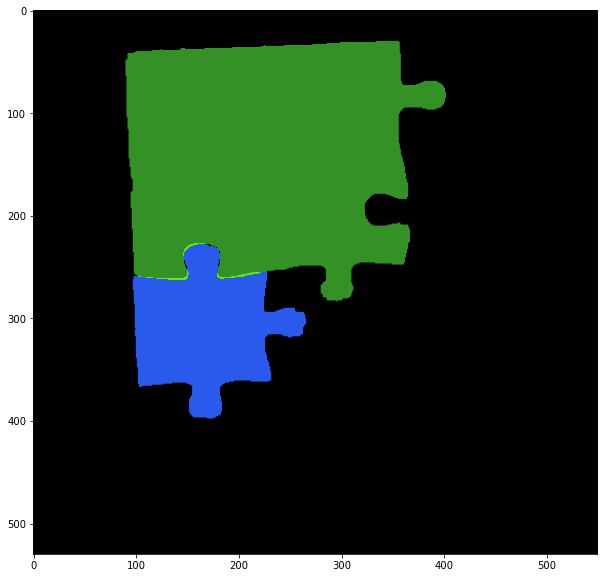

In [24]:
dx, dy, dtheta = get_mating_correction(solved_part, new_piece, solved_edge_loc, new_edge_loc)
dummy_piece = new_piece.copy()
dummy_piece.rotate(dtheta)
x, y = dummy_piece.get_location()
dummy_piece.move_to(x + dx, y + dy)
plan_img = np.zeros(img.shape).astype(np.uint8)
plan_img[solved_part.mask.astype(bool)] += np.array(pieces[0].color).astype(np.uint8)
plan_img[dummy_piece.mask.astype(bool)] += np.array(pieces[1].color).astype(np.uint8)

plt.figure(figsize = (100,10))
plt.imshow(plan_img)